In [2]:
!pip install adversarial-robustness-toolbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.1 MB/s eta 0:00:00


In [7]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist
import torch.nn as nn
import torch.optim as optim

# Load data
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
import torch
# Assuming x_train is a numpy array
x_train = torch.tensor(x_train).float()  # Convert to PyTorch tensor and then to float

# Assuming x_test is a numpy array
x_test = torch.tensor(x_test).float()  # Convert to PyTorch tensor and then to float


# Define simple model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.fc(x)

model = Model()

# Define ART classifier
classifier = PyTorchClassifier(
    model=model,
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10
)

# Train
classifier.fit(x_train, y_train, nb_epochs=3, batch_size=64)

# Create FGSM attacker
attack = FastGradientMethod(estimator=classifier, eps=0.2)

x_test_np = x_test.numpy()  # Convert PyTorch tensor to NumPy array
x_test_adv = attack.generate(x=x_test_np)

# Evaluate
preds = classifier.predict(x_test_adv)
accuracy = (preds.argmax(axis=1) == y_test.argmax(axis=1)).mean()
print("Adversarial accuracy:", accuracy)


Adversarial accuracy: 0.0916


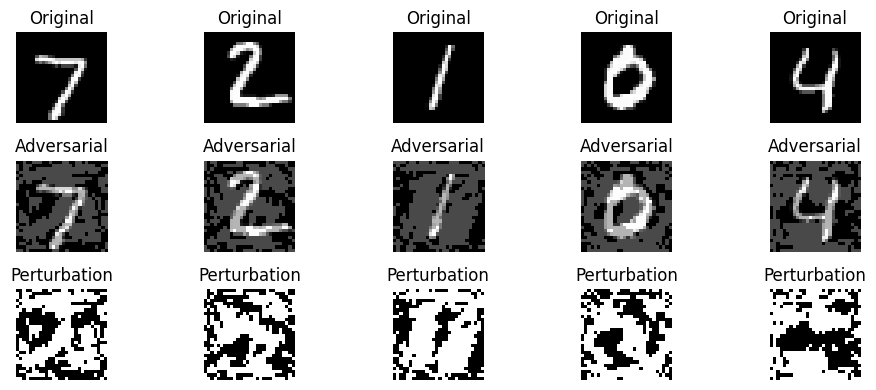

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure both are NumPy arrays
x_test_np = x_test if isinstance(x_test, np.ndarray) else x_test.detach().cpu().numpy()
x_test_adv_np = x_test_adv if isinstance(x_test_adv, np.ndarray) else x_test_adv.detach().cpu().numpy()

# Pick some example indices
indices = [0, 1, 2, 3, 4]

# Plot original, adversarial, and difference
plt.figure(figsize=(10, 4))

for i, idx in enumerate(indices):
    orig = x_test_np[idx]
    adv = x_test_adv_np[idx]
    delta = adv - orig  # Now both are NumPy arrays

    # Original image
    plt.subplot(3, len(indices), i + 1)
    plt.imshow(orig.squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Adversarial image
    plt.subplot(3, len(indices), i + 1 + len(indices))
    plt.imshow(adv.squeeze(), cmap='gray')
    plt.title("Adversarial")
    plt.axis('off')

    # Perturbation (amplified for visibility)
    plt.subplot(3, len(indices), i + 1 + 2 * len(indices))
    plt.imshow((delta * 10).squeeze(), cmap='gray')
    plt.title("Perturbation")
    plt.axis('off')

plt.tight_layout()
plt.show()
